# AI-Powered E-Payment Fraud Detection System

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier # Import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.compose import ColumnTransformer
import warnings
from sklearn import tree
from sklearn import datasets
from sklearn.tree import plot_tree
import warnings

In [2]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

Data Source: https://www.kaggle.com/datasets/ealaxi/paysim1/data

In [3]:
#read the data source into python dataframe
df = pd.read_csv("PS_20174392719_1491204439457_log.csv")

#view dimension of data source
df.shape

(6362620, 11)

In [4]:
# Display the first few rows to understand the structure
print("\n--- First 5 Rows ---")
df.head()


--- First 5 Rows ---


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
#view summary of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
#descriptive or summary statistics
df.describe().astype(int)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620,6362620,6362620,6362620,6362620,6362620,6362620,6362620
mean,243,179861,833883,855113,1100701,1224996,0,0
std,142,603858,2888242,2924048,3399180,3674128,0,0
min,1,0,0,0,0,0,0,0
25%,156,13389,0,0,0,0,0,0
50%,239,74871,14208,0,132705,214661,0,0
75%,335,208721,107315,144258,943036,1111909,0,0
max,743,92445516,59585040,49585040,356015889,356179278,1,1


In [7]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [8]:
df["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

There are 8213 Frauds

In [9]:
df["isFlaggedFraud"].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [10]:
#check for any missing data
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [11]:
round((df["isFraud"].value_counts()[1]/df.shape[0]) * 100,3)

np.float64(0.129)

0.129 percent of the dataset is Fraud

<function matplotlib.pyplot.show(close=None, block=None)>

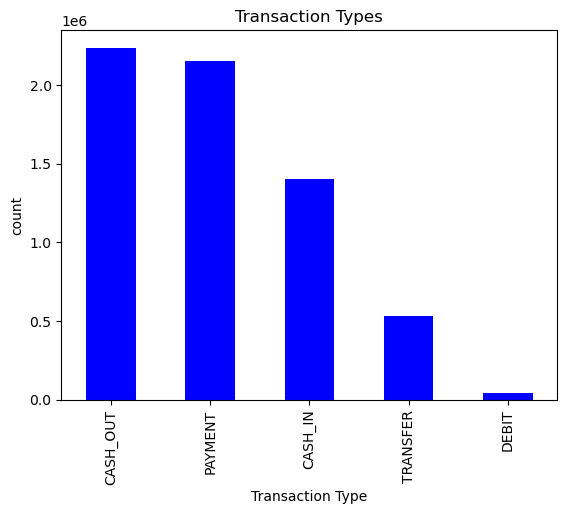

In [12]:
df["type"].value_counts().plot(kind="bar", title="Transaction Types", color = "blue")
plt.xlabel("Transaction Type")
plt.ylabel("count")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

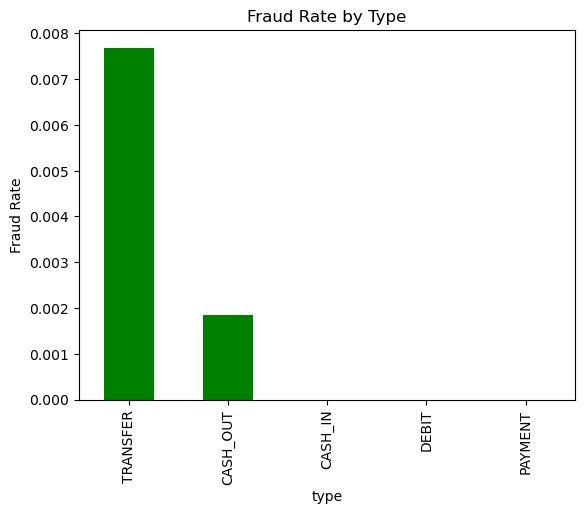

In [13]:
fraud_by_type = df.groupby("type")["isFraud"].mean().sort_values(ascending=False)
fraud_by_type.plot(kind="bar", title="Fraud Rate by Type", color="green")
plt.ylabel("Fraud Rate")
plt.show

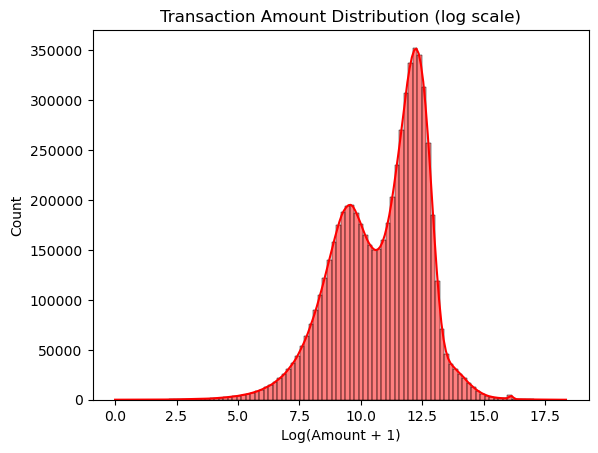

In [14]:
sns.histplot(np.log1p(df["amount"]), bins=100, kde = True, color = 'red')
plt.title("Transaction Amount Distribution (log scale)")
plt.xlabel("Log(Amount + 1)")
plt.show()

### above histogram visualize the distribution of transaction amounts 
applies the natural logarithm transformation, specifically the log(1+x) because transaction amounts often have a highly skewed distribution, with many small transactions and a few very large ones, helps to make the data's distribution more symmetrical

Bimodal distribution - two peaks, 
Highly concentrated - suggests two different types of transactions (TRANSFER and CASH_OUT) while relatively low number for other transactions
Right Skew - 

reading x-axis  a value of 10 on the x-axis corresponds to an original amount of exp(10) - 1, which is approximately $22,025.




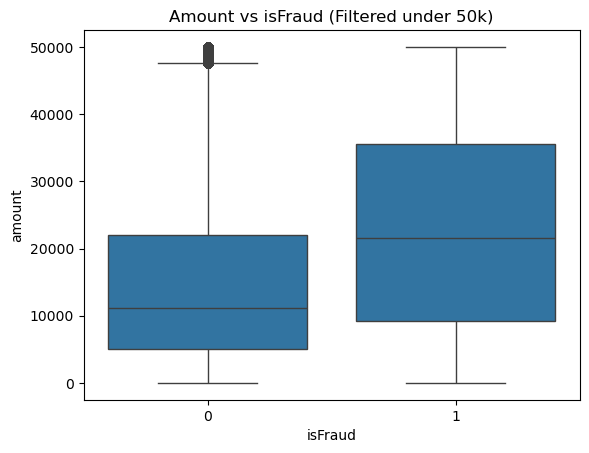

In [15]:
sns.boxplot(data= df[df["amount"] < 50000], x = "isFraud", y = "amount")
plt.title("Amount vs isFraud (Filtered under 50k)")
plt.show()

In [16]:
df["balanceDiffOrig"] = df["oldbalanceOrg"] - df["newbalanceOrig"]
df["balanceDiffDest"] = df["newbalanceDest"] - df["oldbalanceDest"]

In [17]:
df["balanceDiffOrig"] < 0 

0          False
1          False
2          False
3          False
4          False
           ...  
6362615    False
6362616    False
6362617    False
6362618    False
6362619    False
Name: balanceDiffOrig, Length: 6362620, dtype: bool

In [18]:
(df["balanceDiffOrig"] < 0).sum()

np.int64(1399253)

1399253 balance difference of the Original have negative value

In [19]:
(df["balanceDiffDest"] < 0).sum()

np.int64(1238864)

In [20]:
df.head(2)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0


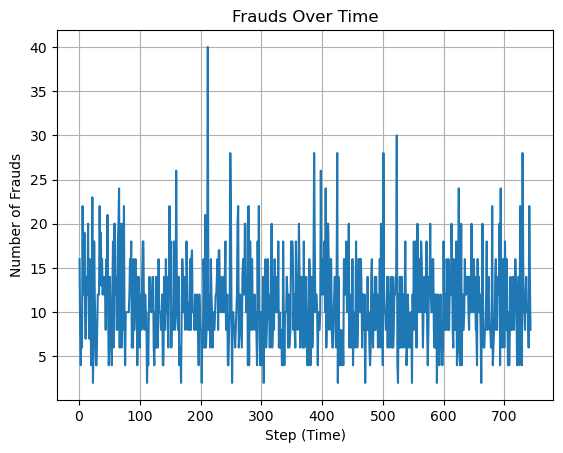

In [21]:
frauds_per_step = df[df["isFraud"] == 1]["step"].value_counts().sort_index()
plt.plot(frauds_per_step.index , frauds_per_step.values, label = "Frauds per Step")
plt.xlabel("Step (Time)")
plt.ylabel("Number of Frauds")
plt.title("Frauds Over Time")
plt.grid(True)
plt.show()

Fraud is not time dependant and hence drop time

In [22]:
df.drop(columns="step",inplace=True)

In [23]:
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,-21182.0
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0


In [24]:
top_senders = df["nameOrig"].value_counts().head(10)

In [25]:
top_senders

nameOrig
C1677795071    3
C1999539787    3
C724452879     3
C1976208114    3
C400299098     3
C1784010646    3
C1530544995    3
C1065307291    3
C545315117     3
C1902386530    3
Name: count, dtype: int64

In [26]:
top_receivers = df["nameDest"].value_counts().head(10)

In [27]:
top_receivers

nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
C1590550415    101
C1789550256     99
C451111351      99
C1360767589     98
C1023714065     97
Name: count, dtype: int64

In [28]:
fraud_users = df[df["isFraud"] == 1]["nameOrig"].value_counts().head(10)

In [29]:
fraud_users

nameOrig
C1280323807    1
C1305486145    1
C840083671     1
C1420196421    1
C2101527076    1
C137533655     1
C1118430673    1
C749981943     1
C1334405552    1
C467632528     1
Name: count, dtype: int64

In [30]:
fraud_types = df[df["type"].isin(["TRANSFER","CASH_OUT"])]

In [31]:
fraud_types.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
2,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,181.0,0.00
3,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,181.0,-21182.00
15,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,15325.0,46430.44
19,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,705.0,-22425.00
24,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,10835.0,2712905.89


In [32]:
fraud_types["type"].value_counts()

type
CASH_OUT    2237500
TRANSFER     532909
Name: count, dtype: int64

Text(0.5, 1.0, 'Fraud Distribution in Transfer & Cash_Out')

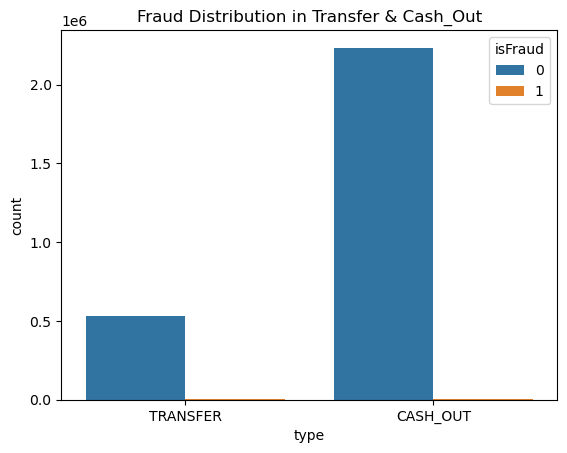

In [33]:
sns.countplot(data=fraud_types, x="type", hue="isFraud")
plt.title("Fraud Distribution in Transfer & Cash_Out")


In [34]:
corr = df[["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest","isFraud"]].corr()

In [35]:
corr

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
amount,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688
oldbalanceOrg,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154
newbalanceOrig,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148
oldbalanceDest,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885
newbalanceDest,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535
isFraud,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000


Text(0.5, 1.0, 'Correlation Matrix')

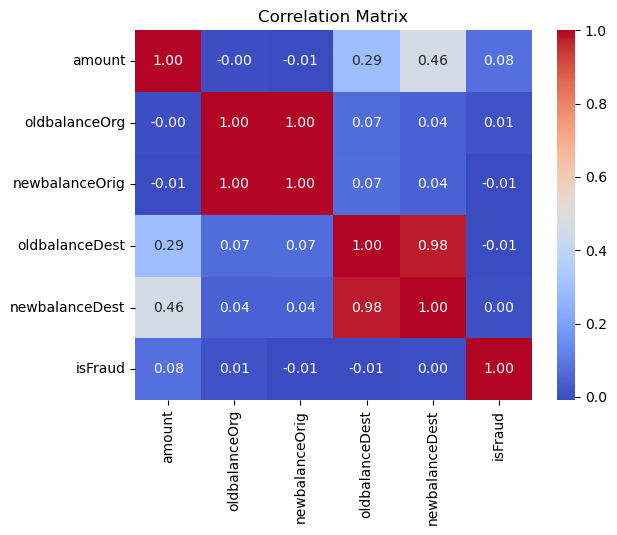

In [36]:
sns.heatmap(corr,annot=True, cmap = "coolwarm", fmt = ".2f")
plt.title("Correlation Matrix")

In [37]:
zero_after_transfer = df[
    (df["oldbalanceOrg"] > 0) &
    (df["newbalanceOrig"] == 0) &
    (df["type"].isin(["TRANSFER","CASH_OUT"]))
]

In [38]:
len(zero_after_transfer)

1188074

In [39]:
zero_after_transfer.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
2,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,181.0,0.00
3,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,181.0,-21182.00
15,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,15325.0,46430.44
19,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,705.0,-22425.00
24,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,10835.0,2712905.89


In [40]:
df["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

## Feature Engineering

In [41]:
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,-21182.0
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0


In [42]:
#select features to be used in modelling

In [43]:
df_model = df.drop(["nameOrig","nameDest","isFlaggedFraud"], axis = 1)

In [44]:
df_model.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,9839.64,0.0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,1864.28,0.0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,181.00,0.0
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,181.00,-21182.0
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,11668.14,0.0


In [45]:
categorical = ["type"]
numeric = ["amount","oldbalanceOrg","newbalanceOrig", "oldbalanceDest", "newbalanceDest"]

In [46]:
X = df_model.drop("isFraud", axis = 1)
y = df_model["isFraud"]

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y)

## Pre-processing

In [48]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric),
        ("cat",OneHotEncoder(drop="first"), categorical)
    ],
    remainder="drop"
)

In [49]:
pipeline = Pipeline([
    ("prep", preprocessor),
    ("clf",LogisticRegression(class_weight="balanced", max_iter=1000))   #balanced so as to handle class imbalance situation
])

NameError: name 'Pipeline' is not defined

In [ ]:
pipeline.fit(X_train, y_train)   #train model with preprocessing 

In [ ]:
y=pred = pipeline.predic(X_test)

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
confusion_matrix(y_test,y_pred)   #model is good at catching fraud but precision is not that good, can try other methods for class imbal like smooth/undersampling

In [ ]:
pipeline.score(X_test, y_test)

https://www.youtube.com/watch?v=4Od5_z28iIE

## Export pipeline

In [ ]:
import joblib
joblib.dump(pipeline,"fraud_detection_pipelinepkl")